# Changes from Model v2.0 (Score 2.3806)

I think the score is worse due to a overfitting problem. I will try to fix it by:

* lowering the number of estimators from 5000 to 1000
* lowering the max depth from 10 to 6
* lowering the min child weight from 7 to 6
* lowering the colsample bytree from 0.9 to 0.8
* lowering the gamma from 0.1 to 1

Updating the parameters for XKB from:

``` python
xgb_base_model = XGBRegressor(
    alpha=1.6728374329132103,
    colsample_bytree=0.9,
    gamma=0.1,
    reg_lambda=20.0,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=7,
    n_estimators=5000,
    subsample=0.8,
    objective='reg:squarederror',
    random_state=42,
)
```

to

``` python
xgb_base_model = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=6,
    colsample_bytree=0.8,
    subsample=0.8,
    gamma=1,
    reg_lambda=10.0,
    alpha=1.0,
    objective='reg:squarederror',
    random_state=42,
)
```

**Result Score: 2.3626**

Conclusion:

* The RMSEs of out train/test splits are great and seem to be improving a lot the predictions.
* This is not the case. I think we have here a overfitting problem.  

# Create a baseline model

In [1]:
import pandas as pd

from data import load_data_selected_features

train_data, additional_train_data, test_data = load_data_selected_features()

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150996 entries, p01_0 to p12_25298
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 585.2+ MB


In [3]:
additional_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [5]:
from pipelines_selected_features import pipeline

all_train_data = pd.concat([train_data, additional_train_data], axis=0)
all_train_data_transformed = pipeline.fit_transform(all_train_data)

train_data_transformed = all_train_data_transformed[:len(train_data)]
additional_train_data_transformed = all_train_data_transformed[len(train_data):]

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_additional_train = additional_train_data_transformed.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data_transformed['bg+1:00']

## Create the model

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge

hgb_estimator = HistGradientBoostingRegressor(
    l2_regularization=0.0001,
    learning_rate=0.1,
    max_depth=11,
    max_iter=1500,
    min_samples_leaf=10,
    n_iter_no_change=22,
    random_state=42,
)

lasso_lars_ic_base_model = LassoLarsIC(
    criterion='aic',
    eps=0.03922948513965659,
    max_iter=1944,
    noise_variance=5.4116687755186035e-05,
    positive=False,
)
knn_base_model = KNeighborsRegressor(n_neighbors=5)

xgb_base_model = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=6,
    colsample_bytree=0.8,
    subsample=0.8,
    gamma=1,
    reg_lambda=10.0,
    reg_alpha=1.0,
    objective='reg:squarederror',
    random_state=42,
)

estimators = [
    ('hgb', hgb_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_model),
    ('knn', knn_base_model),
    ('xgb', xgb_base_model),
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=-1, verbose=2)

13:47:53 - 13:47:53 - Start training
13:47:53 - 13:47:53 - Calculate performance for hgb
13:47:53 - 13:47:53 - Splitting the additional train data with ShuffleSplit
13:47:53 - 13:47:53 - Split 1 - Model: hgb
13:47:53 - 13:47:53 - Fitting the model
13:48:40 - 13:48:40 - Predicting
13:48:40 - 13:48:40 - Calculating scores
13:48:41 - 13:48:41 - R^2: 0.6802980598686639, RMSE: 1.853234323545247, MAE: 1.3781103796392653, MSE: 3.4344774579662096
13:48:41 - 13:48:41 - Split 2 - Model: hgb
13:48:41 - 13:48:41 - Fitting the model
13:49:31 - 13:49:31 - Predicting
13:49:32 - 13:49:32 - Calculating scores
13:49:32 - 13:49:32 - R^2: 0.6790084797635141, RMSE: 1.8599546082369873, MAE: 1.389380261014941, MSE: 3.4594311447020054
13:49:32 - 13:49:32 - Split 3 - Model: hgb
13:49:32 - 13:49:32 - Fitting the model
13:50:16 - 13:50:16 - Predicting
13:50:16 - 13:50:16 - Calculating scores
13:50:16 - 13:50:16 - R^2: 0.6768352388557501, RMSE: 1.8473604416799103, MAE: 1.3794091734729261, MSE: 3.4127406014837933


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


13:58:28 - 13:58:28 - Predicting
13:58:38 - 13:58:38 - Calculating scores
13:58:47 - 13:58:47 - R^2: 0.6869341464575202, RMSE: 1.833899574779076, MAE: 1.3491835990504124, MSE: 3.363187650374876
13:58:47 - 13:58:47 - Split 2 - Model: stacking_regressor
13:58:47 - 13:58:47 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.1s remaining:    9.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.9min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


14:04:23 - 14:04:23 - Predicting
14:04:33 - 14:04:33 - Calculating scores
14:04:43 - 14:04:43 - R^2: 0.6834063597490048, RMSE: 1.847169116844679, MAE: 1.3642803020366578, MSE: 3.4120337462247514
14:04:43 - 14:04:43 - Split 3 - Model: stacking_regressor
14:04:43 - 14:04:43 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.4min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


14:09:57 - 14:09:57 - Predicting
14:10:07 - 14:10:07 - Calculating scores
14:10:18 - 14:10:18 - R^2: 0.6839889571144196, RMSE: 1.8267990213148069, MAE: 1.3478135003941412, MSE: 3.337194664276736
14:10:18 - 14:10:18 - Split 4 - Model: stacking_regressor
14:10:19 - 14:10:19 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.4s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.9min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


14:15:54 - 14:15:54 - Predicting
14:16:05 - 14:16:05 - Calculating scores
14:16:15 - 14:16:15 - R^2: 0.6842461018249582, RMSE: 1.8473527969046275, MAE: 1.364337762275337, MSE: 3.41271235623135
14:16:15 - 14:16:15 - Split 5 - Model: stacking_regressor
14:16:15 - 14:16:15 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.5min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished


14:21:31 - 14:21:31 - Predicting
14:21:41 - 14:21:41 - Calculating scores
14:21:50 - 14:21:50 - R^2: 0.6785664816773502, RMSE: 1.8402911480757105, MAE: 1.358029650061447, MSE: 3.3866715096858164
14:21:50 - 14:21:50 - Training finished


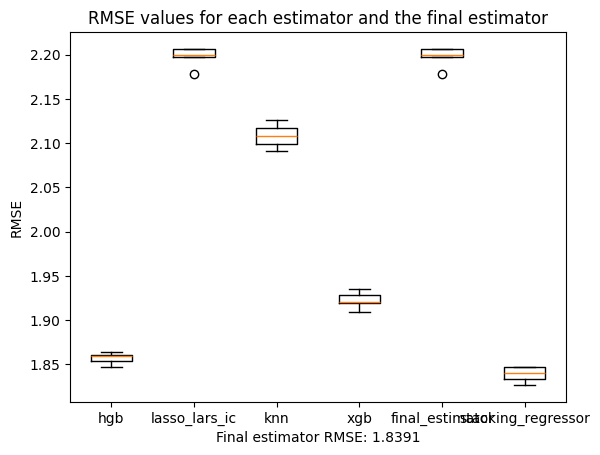

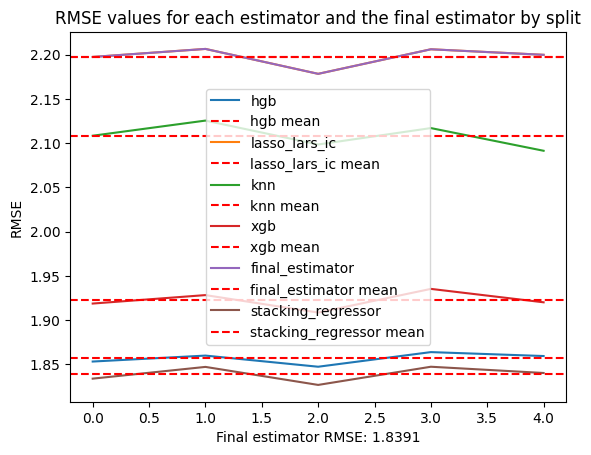

In [7]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'{date_time}-model-stacking-tuned-LLIC-HGB-XGB'

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, X_additional_train, y_additional_train, n_splits=5)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

## Predict test data

In [8]:
import numpy as np
from pipelines_selected_features import pipeline

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, additional_train_data], axis=0))
X_train = all_train_data_transformed.drop(columns=['bg+1:00'])
y_train = all_train_data_transformed['bg+1:00']

model.fit(X_train, y_train)

X_test = pipeline.transform(test_data)

y_pred = model.predict(X_test)

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.0s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.932759
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,5.806801
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.099743
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.834941
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.738557


In [9]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,8.932759
p01_8460,5.806801
p01_8461,8.099743
p01_8462,10.834941
p01_8463,6.738557
...,...
p24_256,6.108617
p24_257,10.166881
p24_258,6.361659


In [10]:
submission.to_csv(f'submission-{model_name}.csv')